In [1]:
from dataset import Dataset
from feature_extractor import *
from monitors import *
from evaluation import Evaluator
import torch
from models import resnet
import pandas as pd
import os
import csv

In [2]:
# Stat

import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

In [3]:
batch_size = 10
device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853668/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
all_id_datasets = ["cifar10", "svhn", "cifar100"]

all_ood_datasets = [["cifar100", "svhn", "lsun"],
                    ["cifar10", "tiny_imagenet", "lsun"],
                    ["cifar10", "svhn", "lsun"]]

all_perturbations = ["brightness", "blur", "pixelization"]

all_attacks = ["fgsm", "deepfool", "pgd"]


react_clip = [0.8, 0.9, 0.95, 0.99]
monitor_temperature = [1, 50, 75, 100]


all_models = ["resnet", "densenet"]

all_layers_ids = [[32], [98]]

cv = 5


In [5]:
aupr_results = {
    '1': [], 
    '50': [],
    '75': [],
    '100': [],
}

auroc_results = {
    '1': [], 
    '50': [],
    '75': [],
    '100': [],
}

tnr95_results = {
    '1': [], 
    '50': [],
    '75': [],
    '100': [],
}


def display_result_posthoc_nemenyi_friedman(data, alpha=0.05, display=False):

    # Step 1: Perform the Friedman test
    friedman_stat, p_value = ss.friedmanchisquare(*data)
    print("Friedman chi-squared statistic:", friedman_stat)
    print("p-value:", p_value)
    
    # Step 2: Perform the post hoc Nemenyi test
    if p_value < alpha:  # Adjust the significance level as needed
        nemenyi_results = sp.posthoc_nemenyi_friedman(data.T)
        
        if display == True:
            # Compare mean of each group with every other group
            for i in range(len(nemenyi_results)):
                for j in range(i + 1, len(nemenyi_results)):
                    group1 = f"Case {i}"
                    group2 = f"Case {j}"
                    if nemenyi_results.iloc[i, j] < alpha:  # Adjust the significance level as needed
                        if np.mean(data[:, i]) > np.mean(data[:, j]):
                            print(f"...{group1} is significantly greater than {group2}.")
                        else:
                            print(f"...{group1} is significantly less than {group2}.")
                    else:
                        print(f"...There is no significant difference between {group1} and {group2}.")
        return nemenyi_results
    else: 
        print('No significant differences between groups!')
        return None #no significance, p-value bigger than alpha
    
    

In [6]:
for h in range(len(all_models)):
    model = all_models[h]
    for layer in all_layers_ids[h]:
        for n in range(len(all_id_datasets)):
            id_dataset = all_id_datasets[n]
            for i in range(len(all_ood_datasets[n])):
                ood_dataset = all_ood_datasets[n][i]

                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(ood_dataset, "test", model, None, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)
                features_train, logits_train, softmax_train, pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)

                
                
                
                for temp in monitor_temperature:

                    # Moniteur EnergyMonitor
                    monitor_energy = EnergyMonitor(temperature=temp)
                    monitor_energy.fit()

                    scores_test_energy = monitor_energy.predict(logits_test)
                    scores_ood_energy = monitor_energy.predict(logits_ood)

                    aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                    auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                    tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                    
                    # Stocker les résultats dans le dictionnaire
                    aupr_results[str(temp)] += [aupr_energy]
                    auroc_results[str(temp)] += [auroc_energy]
                    tnr95_results[str(temp)] += [tnr95tpr_energy]
                    
                    
                    
                
            
            for k in range(len(all_attacks)):
                ood_dataset = id_dataset

                adversarial_attack = all_attacks[k]
                

                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, None, adversarial_attack, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)
                    
                    
                for temp in monitor_temperature:

                    # Moniteur EnergyMonitor
                    monitor_energy = EnergyMonitor(temperature=temp)
                    monitor_energy.fit()

                    scores_test_energy = monitor_energy.predict(logits_test)
                    scores_ood_energy = monitor_energy.predict(logits_ood)

                    aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                    auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                    tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                    # Stocker les résultats dans le dictionnaire
                    aupr_results[str(temp)] += [aupr_energy]
                    auroc_results[str(temp)] += [auroc_energy]
                    tnr95_results[str(temp)] += [tnr95tpr_energy]
                   
                    
            for j in range(len(all_perturbations)):
                ood_dataset = id_dataset

                additional_transform = all_perturbations[j]


                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, additional_transform, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)
                
                
                for temp in monitor_temperature:
                    # Moniteur EnergyMonitor
                    monitor_energy = EnergyMonitor(temperature=temp)
                    monitor_energy.fit()

                    scores_test_energy = monitor_energy.predict(logits_test)
                    scores_ood_energy = monitor_energy.predict(logits_ood)

                    aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                    auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                    tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                     # Stocker les résultats dans le dictionnaire
                    aupr_results[str(temp)] += [aupr_energy]
                    auroc_results[str(temp)] += [auroc_energy]
                    tnr95_results[str(temp)] += [tnr95tpr_energy]
                   
                    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./Data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and v

In [7]:
aupr_results
auroc_results
tnr95_results

{'1': [0.5075264225472402,
  0.7568058076225046,
  0.7418597202946514,
  0.571151401619054,
  0.5341085271317829,
  0.1566638489715413,
  0.5519811954331766,
  0.7227814202604119,
  0.529920640594838,
  0.3437562080336922,
  0.44697842584131275,
  0.22925026818705552,
  0.5828327199335154,
  0.4447199402539208,
  0.0007901907356948623,
  0.6446351721439749,
  0.21427981840693355,
  0.21181952132531556,
  0.41575185090630584,
  0.49463875414858305,
  0.44357926984937457,
  0.5368400696190292,
  0.463291649858814,
  0.0003592384145610916,
  0.5539807856939027,
  0.3261132623426912,
  0.47796104743267165,
  0.6589977938859124,
  0.6979724761004307,
  0.9356024792520222,
  0.6419744563341387,
  0.5400083787180561,
  0.015307150050352436,
  0.4406638427886952,
  0.3320776040685628,
  0.531305770374777,
  0.3206983140021523,
  0.48961696360955,
  0.43066682609908724,
  0.45734692429581625,
  0.36629760739122796,
  0.0,
  0.11836826235390863,
  0.21461890878800505,
  0.1558758270533912,
  0.2

In [8]:
from _plotting import _bron_kerbosch, _find_maximal_cliques, sign_plot, sign_table, sign_array
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from _plotting import *


def critical_difference_diagram(
        ranks: Union[dict, Series],
        sig_matrix: DataFrame,
        *,
        ax: SubplotBase = None,
        label_fmt_left: str = '{label} ({rank:.3g})',
        label_fmt_right: str = '({rank:.3g}) {label}',
        label_props: dict = None,
        marker_props: dict = None,
        elbow_props: dict = None,
        crossbar_props: dict = None,
        text_h_margin: float = 0.01) -> Dict[str, list]:
    
    """Plot a Critical Difference diagram from ranks and post-hoc results.

    The diagram arranges the average ranks of multiple groups on the x axis
    in order to facilitate performance comparisons between them. The groups
    that could not be statistically deemed as different are linked by a
    horizontal crossbar [1], [2].

    ::

                      rank markers
         X axis ---------O----O-------------------O-O------------O---------
                         |----|                   | |            |
                         |    |                   |---crossbar---|
                clf1 ----|    |                   | |            |---- clf3
                clf2 ---------|                   | |----------------- clf4
                                                  |------------------- clf5
                    |__|
                text_h_margin

    In the drawing above, the two crossbars indicate that clf1 and clf2 cannot
    be statistically differentiated, the same occurring between clf3, clf4 and
    clf5. However, clf1 and clf2 are each significantly lower ranked than clf3,
    clf4 and clf5.

    """
    elbow_props = elbow_props or {}
    marker_props = {"zorder": 3, **(marker_props or {})}
    label_props = {"va": "center", **(label_props or {})}
    crossbar_props = {"color": "k", "zorder": 3,
                      "linewidth": 5, **(crossbar_props or {})}########### MODIFIED BY USER

    ax = ax or pyplot.gca()
    ax.yaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_position('zero')

    # lists of artists to be returned
    markers = []
    elbows = []
    labels = []
    crossbars = []

    # True if pairwise comparison is NOT significant
    adj_matrix = DataFrame(
        1 - sign_array(sig_matrix),
        index=sig_matrix.index,
        columns=sig_matrix.columns,
        dtype=bool,
    )
    
    ranks = Series(ranks)  # Standardize if ranks is dict
    points_left, points_right = np.array_split(ranks.sort_values(), 2)
    
    # Sets of points under the same crossbar
    crossbar_sets = _find_maximal_cliques(adj_matrix)

    # Sort by lowest rank and filter single-valued sets
    crossbar_sets = sorted(
        (x for x in crossbar_sets if len(x) > 1),
        key=lambda x: ranks[list(x)].min()
    )

    # Create stacking of crossbars: for each level, try to fit the crossbar,
    # so that it does not intersect with any other in the level. If it does not
    # fit in any level, create a new level for it.
    crossbar_levels: list[list[set]] = []
    for bar in crossbar_sets:
        for level, bars_in_level in enumerate(crossbar_levels):
            if not any(bool(bar & bar_in_lvl) for bar_in_lvl in bars_in_level):
                ypos = -level-1
                bars_in_level.append(bar)
                break
        else:
            ypos = -len(crossbar_levels) - 1
            crossbar_levels.append([bar])

        crossbars.append(ax.plot(
            # Adding a separate line between each pair enables showing a
            # marker over each elbow with crossbar_props={'marker': 'o'}.
            [ranks[i] for i in bar],
            [ypos] * len(bar),
            **crossbar_props,
        ))

    lowest_crossbar_ypos = -len(crossbar_levels)
    
    custom_color = ['red', 'orange', 'green', 'blue'] ########### ADDED BY USER
    label_to_color = dict(zip(list(ranks.index), custom_color)) ########### ADDED BY USER
    
    def plot_items(points, xpos, label_fmt, label_props):
        """Plot each marker + elbow + label."""
        ypos = lowest_crossbar_ypos - 0.5 ########### MODIFIED BY USER
        for i, (label, rank) in enumerate(points.items()):
            curr_color = label_to_color[label] ########### ADDED BY USER

            elbow, *_ = ax.plot(
                [xpos, rank, rank],
                [ypos, ypos, 0],
                **{"color": curr_color, **elbow_props},########### ADDED BY USER
            )
            elbows.append(elbow)
            markers.append(
                ax.scatter(rank, 0, **{"color": curr_color, **marker_props})########### ADDED BY USER
            )
            labels.append(
                ax.text(
                    xpos,
                    ypos,
                    label_fmt.format(label=label, rank=rank),
                    **{"color": curr_color, **label_props},########### ADDED BY USER
                )
            )
            ypos -= 1

    plot_items(
        points_left,
        xpos=points_left.iloc[0] - text_h_margin,
        label_fmt=label_fmt_left,
        label_props={"ha": "right", **label_props},
    )
    plot_items(
        points_right[::-1],
        xpos=points_right.iloc[-1] + text_h_margin,
        label_fmt=label_fmt_right,
        label_props={"ha": "left", **label_props},
    )

    return {
        "markers": markers,
        "elbows": elbows,
        "labels": labels,
        "crossbars": crossbars,
    }

alpha = 0.05  

# AUROC
print("Post-hoc Nemenyi test for AUROC:")
nemenyi_auroc = display_result_posthoc_nemenyi_friedman(np.array(list(auroc_results.values())), alpha=alpha, display=True)

# AUPR
print("\nPost-hoc Nemenyi test for AUPR:")
nemenyi_aupr = display_result_posthoc_nemenyi_friedman(np.array(list(aupr_results.values())), alpha=alpha, display=True)

# TNR95
print("\nPost-hoc Nemenyi test for TNR95:")
nemenyi_tnr95 = display_result_posthoc_nemenyi_friedman(np.array(list(tnr95_results.values())), alpha=alpha, display=True)



{'markers': [<matplotlib.collections.PathCollection at 0x7fce8a52ad10>,
 'elbows': [<matplotlib.lines.Line2D at 0x7fcdd5f65a80>,
 'labels': [Text(0.2677777777777778, -1.5, '100 (0.278)'),
  Text(0.2677777777777778, -2.5, '75 (0.528)'),
  Text(0.9266666666666666, -1.5, '(0.917) 1'),
  Text(0.9266666666666666, -2.5, '(0.778) 50')],
 'crossbars': [[<matplotlib.lines.Line2D at 0x7fcdd5f67310>]]}

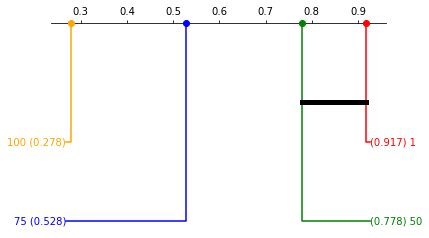

In [9]:
# Post-hoc Nemenyi test for AUPR:

dict_data_aupr = aupr_results 
data_df_aupr = (
  pd.DataFrame(dict_data_aupr)
  .rename_axis('cv_fold')
  .melt(
      var_name='estimator',
      value_name='score',
      ignore_index=False,
  )
  .reset_index()
)
avg_rank_aupr = data_df_aupr.groupby('cv_fold').score.rank(pct=True).groupby(data_df_aupr.estimator).mean()
ss.friedmanchisquare(*dict_data_aupr.values())
test_results_aupr = sp.posthoc_nemenyi_friedman(
     data_df_aupr,
     melted=True,
     block_col='cv_fold',
     group_col='estimator',
     y_col='score',
 )
test_results_aupr
critical_difference_diagram(avg_rank_aupr, test_results_aupr)

{'markers': [<matplotlib.collections.PathCollection at 0x7fcdced28be0>,
 'elbows': [<matplotlib.lines.Line2D at 0x7fcdceb482e0>,
 'labels': [Text(0.24462962962962964, -0.5, '100 (0.255)'),
  Text(0.24462962962962964, -1.5, '75 (0.505)'),
  Text(0.9961111111111112, -0.5, '(0.986) 1'),
  Text(0.9961111111111112, -1.5, '(0.755) 50')],
 'crossbars': []}

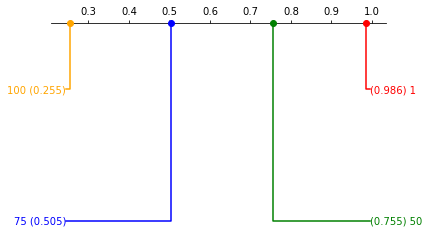

In [10]:
#Post-hoc Nemenyi test for AUROC:
    
dict_data_auroc = auroc_results 
data_df_auroc = (
  pd.DataFrame(dict_data_auroc)
  .rename_axis('cv_fold')
  .melt(
      var_name='estimator',
      value_name='score',
      ignore_index=False,
  )
  .reset_index()
)
avg_rank_auroc = data_df_auroc.groupby('cv_fold').score.rank(pct=True).groupby(data_df_auroc.estimator).mean()
ss.friedmanchisquare(*dict_data_auroc.values())
test_results_auroc = sp.posthoc_nemenyi_friedman(
     data_df_auroc,
     melted=True,
     block_col='cv_fold',
     group_col='estimator',
     y_col='score',
 )
test_results_auroc
critical_difference_diagram(avg_rank_auroc, test_results_auroc)

{'markers': [<matplotlib.collections.PathCollection at 0x7fcdcec22e30>,
 'elbows': [<matplotlib.lines.Line2D at 0x7fcdcebd3310>,
 'labels': [Text(0.2677777777777778, -0.5, '100 (0.278)'),
  Text(0.2677777777777778, -1.5, '75 (0.5)'),
  Text(0.9961111111111112, -0.5, '(0.986) 1'),
  Text(0.9961111111111112, -1.5, '(0.736) 50')],
 'crossbars': []}

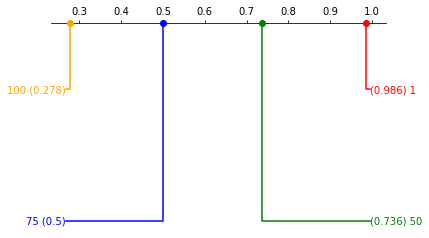

In [11]:
# Post-hoc Nemenyi test for TNR95-TPR:

dict_data_tnr95 = tnr95_results 
data_df_tnr95 = (
  pd.DataFrame(dict_data_tnr95)
  .rename_axis('cv_fold')
  .melt(
      var_name='estimator',
      value_name='score',
      ignore_index=False,
  )
  .reset_index()
)
avg_rank_tnr95  = data_df_tnr95.groupby('cv_fold').score.rank(pct=True).groupby(data_df_tnr95.estimator).mean()
ss.friedmanchisquare(*dict_data_tnr95.values())
test_results_tnr95 = sp.posthoc_nemenyi_friedman(
     data_df_tnr95,
     melted=True,
     block_col='cv_fold',
     group_col='estimator',
     y_col='score',
 )
test_results_tnr95 
critical_difference_diagram(avg_rank_tnr95, test_results_tnr95 )